In [1]:
from os import getcwd
from os.path import abspath, join

from copy import deepcopy
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from tqdm import tqdm

from src.data.load_dataset import generate_frequency_detection
from src.models.estimator import RFClassifier, relu
from src.models.weights import sensilla_weights, classical_weights

In [2]:
data_dir = abspath(join(getcwd(), '../../'))

#### Time-series of $0.1$s sampled at $2000$ Hz with $f_1=50$ Hz

In [3]:
# load data
num_samples, sampling_rate, duration, freq, snr, seed = 7000, 2000, 0.1, 50, 0.8, 5
X, y = generate_frequency_detection(num_samples, sampling_rate, freq, duration, snr, seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

# params
num_neurons = sorted(set(np.logspace(0, 3, 50).astype('int')))
num_trials = 5
nonlinearity = relu
bias = 0
scale = 1
clf = LinearSVC(tol=1e-4, max_iter=1000)
n_jobs=6

#### Mechanosensory weights with $f_{lo}=20$Hz, $f_{hi}=80$Hz, and $\gamma=0.05$s

In [4]:
kwargs = {'sampling_rate':sampling_rate, 'duration': duration, 'lowcut':20, 'highcut':80, 'decay_coef':0.05, 'scale': scale}
test_sensilla = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    # declare classifier, fit in parallel, and compute output score
    classifiers = [RFClassifier(n, sensilla_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
    test_sensilla['mean'].append(np.mean(test_accuracy))
    test_sensilla['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_sensilla['hidden_size'].append(n)

  0%|          | 0/42 [00:00<?, ?it/s]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
  2%|▏         | 1/42 [00:01<01:19,  1.94s/it]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
  5%|▍         | 2/42 [00:03<01:13,  1.83s/it]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to conve

#### Classical weights

In [15]:
kwargs = {'scale':scale}
test_classical = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    # declare classifier, fit in parallel, and compute accuracy
    classifiers = [RFClassifier(n, classical_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
    test_classical['mean'].append(np.mean(test_accuracy))
    test_classical['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_classical['hidden_size'].append(n)

  0%|          | 0/42 [00:00<?, ?it/s]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
  2%|▏         | 1/42 [00:01<01:13,  1.79s/it]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
  5%|▍         | 2/42 [00:02<00:45,  1.14s/it]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
  7%|▋         | 3/42 [00:03<00:33,  1.16it/s]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985:

#### Incompatible weights with $f_{lo}=10$Hz, $f_{hi}=40$Hz, and $\gamma=0.05$s

In [16]:
kwargs = {'sampling_rate':sampling_rate, 'duration': duration, 'lowcut':10, 'highcut':40, 'decay_coef':0.05, 'scale': scale}
test_incompatible = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    # declare classifier, fit in parallel, and compute output score
    classifiers = [RFClassifier(n, sensilla_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
    test_incompatible['mean'].append(np.mean(test_accuracy))
    test_incompatible['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_incompatible['hidden_size'].append(n)

  0%|          | 0/42 [00:00<?, ?it/s]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
  2%|▏         | 1/42 [00:01<00:42,  1.03s/it]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
  5%|▍         | 2/42 [00:02<00:58,  1.46s/it]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to conve

In [19]:
# save
test = {'sensilla': test_sensilla, 'classical': test_classical, 'incompatible': test_incompatible}
data_dir = abspath(join(getcwd(), '../../'))
with open(data_dir + '/models/results/freq_detection/freq_detection_sensilla_estimator.pickle', 'wb') as handle:
    pickle.dump(test, handle, protocol=pickle.HIGHEST_PROTOCOL) 

sensilla, (281, 0.0143)
classical, (281, 0.7714)
incompatible, (281, 20.2143)


([<matplotlib.axis.XTick at 0x7f8839a4c790>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

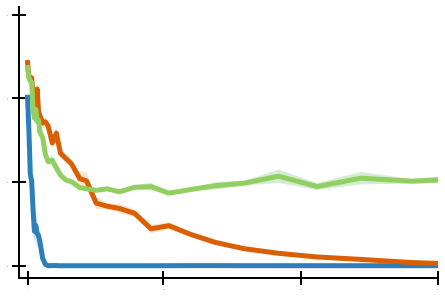

In [47]:
colors = {'sensilla': '#2c7fb8', 'classical': '#d95f02', 'incompatible': '#91cf60'}

fig = plt.figure(figsize=(7.5, 5))
ax = fig.add_subplot(111)
for key, col in colors.items():
    avg_test_err = 1 - np.array(test[key]['mean'])
    std_err = np.array(test[key]['std_err'])
    plt.plot(num_neurons, avg_test_err, label=key, lw=5, c=col)
    plt.fill_between(num_neurons, avg_test_err - std_err, avg_test_err + std_err, alpha=0.2)
    print('%s, (%s, %0.4f)' % (key, num_neurons[32], avg_test_err[32] * 100))
    
# format axes
for axis in ['left', 'bottom']:
    ax.spines[axis].set_linewidth(2)
for axis in ['top', 'right']:
    ax.spines[axis].set_visible(False)
    
# format ticks
ax.tick_params(axis = 'both', which = 'major', direction='inout', labelsize = 0, width=2, length=14)
plt.xlim([-5, 300])
plt.yticks(np.arange(0, 0.65, 0.2))
plt.ylim([-0.03, 0.62])
plt.xticks([1, 100, 200, 300])